# Trying out Logistic Regression

In this tutorial, we'll cover an entire Logistic Regression model training pipeline.
Our main steps will be:
- Loading and visualizing our dataset;
- Applying some basic data pre-processing techniques;
- (efficiently) implementing a Logistic Regression model and training routine from scratch;
- Basic model evaluation;

Let's first import our libraries. The three main libs to be used are `numpy`, `pandas` and `matplotlib`.

In [35]:
import itertools as it
import pprint
import time

#numerical stuff
import numpy as np

#tables manipulation and statistics
import pandas as pd

#plotting utilities
from matplotlib import pyplot as plt
from matplotlib import style
from matplotlib import colors as mpl_colors
plt.rcParams['figure.figsize'] = [12, 8]
style.use('ggplot')

## Loading the dataset
Let's now load our dataset. It has already been split between train and test sets.
We'll be exploring a very simple, synthetic dataset. It's composed of only two variables (`x1` and `x2`) and our target value (`y`), which is a binary value. It's either `1` or `0`.

In [2]:
df = pd.read_csv('data/dataset_train.csv')
df_test = pd.read_csv('data/dataset_test.csv')

print('table head:')
print(df.head())
print()
print(f'number of samples: train={df.shape[0]}, test={df_test.shape[0]}')

table head:
         x1          x2  y
0  9.446993   67.039048  0
1  6.799618   43.639946  0
2  7.068136   29.148055  0
3  3.902750   30.937869  0
4  7.566385  107.487549  0

number of samples: train=7553, test=2447


## Visualizing the dataset

It's always a good practice to spend some time trying to understand the dataset before developing any model.
Visualizations can provide many useful insights.

Since we're dealing with only 2 variables, it is possible to plot the dataset, painting each point according to it's class. Let's write a little method to do it:

In [3]:
def visualize_classes(df, show=True, title='Positive and negative classes'):
    #positive/negative rows
    pos_df = df[df.y > 0]
    neg_df = df[df.y <= 0]
    
    plt.scatter(pos_df.x1.values, pos_df.x2.values, color='green', label='positive')
    plt.scatter(neg_df.x1.values, neg_df.x2.values, color='red', label='negative')
    plt.legend(loc='upper right', facecolor='white')
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    
    if show:
        plt.show()

Now we can run this method on a random sample of 1000 datapoints:

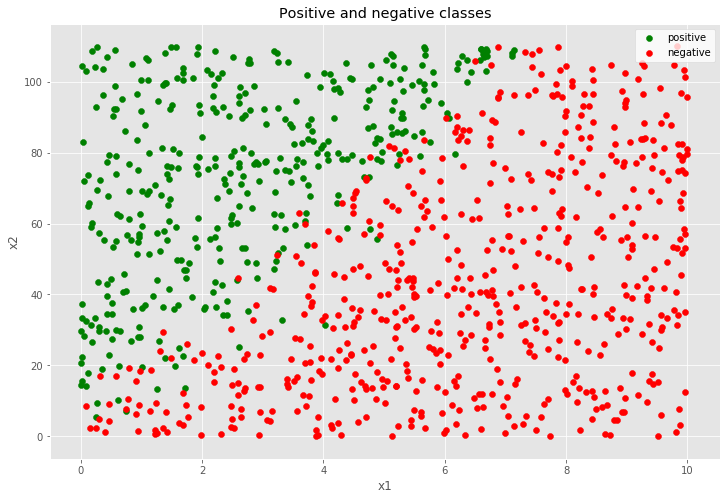

number of positive samples: 2767/7553 (36.63%)


In [36]:
visualize_classes(df.sample(n=1000))
print(f'number of positive samples: {df.y.sum()}/{df.shape[0]} ({100*df.y.mean():.2f}%)')

Visualizing it was good because now we see that it is pretty separable!
Another insight we get is that `x1` and `x2` are on different ranges.
Let's inspect the distributions of both variables:

In [5]:
def histogram(z, label, n_bins=None):
    if n_bins is None:
        n_bins = int(np.percentile(z, 98) - np.percentile(z, 2))
    plt.hist(z, bins=n_bins, label=label)


def visualize_distributions(df, n_bins=None, title='X histograms'):
    histogram(df.x1.values, label='x1', n_bins=n_bins)
    histogram(df.x2.values, label='x2', n_bins=n_bins)
    plt.title(title)
    plt.xlabel('value')
    plt.ylabel('frequency')
    plt.legend(loc='upper right')
    plt.show()

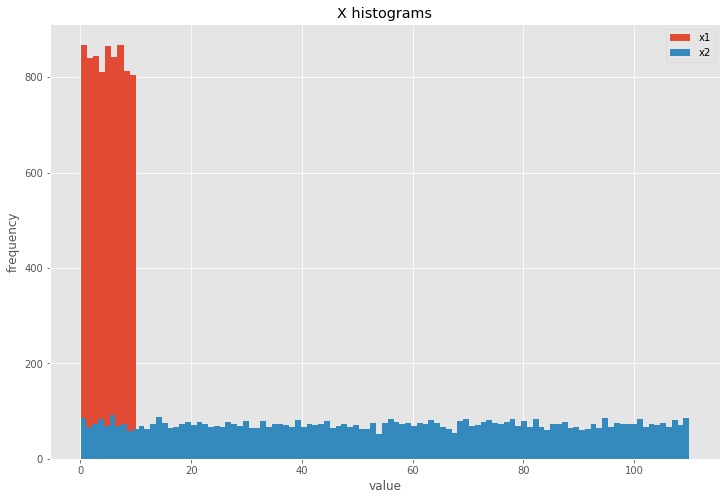

dataset statistics:
x1: mean=4.9606, std=2.8764
x2: mean=55.1325, std=31.9056


In [37]:
visualize_distributions(df)
print('dataset statistics:')
print(f'x1: mean={df.x1.mean():.4f}, std={df.x1.std():.4f}')
print(f'x2: mean={df.x2.mean():.4f}, std={df.x2.std():.4f}')

While both variables clearly follow an *uniform* distribution, `x1` is concentrated somewhere around `[0, 10]` while `x2` is uniformly distributed accross `[0, 110]`.

This reminds us of a very important step: **normalization**! We need to perform normalization otherwise the optimization step will perform poorly.
Before that, we need to *split* our training data into *train* and *validation* sets. We'll use validation during optimization so this part of the data *must not* be used for normalization:

In [7]:
def train_val_split(df, val_frac, rand_seed=None):
    rand = np.random.RandomState(seed=rand_seed)
    val = (rand.uniform(0, 1, size=df.shape[0]) <= val_frac)
    df_val = df[val == 1]
    df = df[val == 0]
    return df, df_val

We choose to use approximately 25% of our data for validation and the rest for training:

In [8]:
df_train, df_val = train_val_split(df, val_frac=0.25, rand_seed=89)
print(f'number of samples: train={df_train.shape[0]}, test={df_val.shape[0]}')

number of samples: train=5594, test=1959


We can now use the train set for normalization.
We'll normalize each *feature* (that is, `x1` and `x2`) by subtracting the mean and dividing by the standard deviation. So we compute the train set statistics:

In [9]:
def get_statistics(z):
    return {
        'mean': z.mean(),
        'std': z.std(),
    }

In [10]:
train_stats = {
    'x1': get_statistics(df_train.x1),
    'x2': get_statistics(df_train.x2),
}

print('train statistics:')
pprint.pprint(train_stats)

train statistics:
{'x1': {'mean': 4.968817103214029, 'std': 2.8725543215283094},
 'x2': {'mean': 54.69701712988299, 'std': 31.97130678697082}}


And now we can finally normalize both the train and validation sets with the train set statistics:

In [11]:
def normalize(z, mean, std, eps=1e-12):
    return (z - mean)/(std + eps)


def normalize_dataset(df, statistics):
    rows = {'y': df.y.values}
    for key, stats in statistics.items():
        rows[key] = normalize(df[key], stats['mean'], stats['std'])
    return pd.DataFrame(rows, columns=df.columns)

And now we see that both `x1` and `x2` are now in the same range of values:

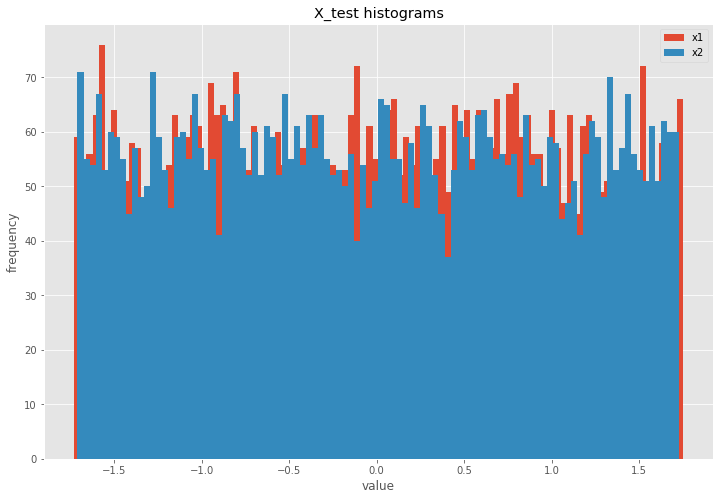

In [38]:
df_train_norm = normalize_dataset(df_train, train_stats)
df_val_norm = normalize_dataset(df_val, train_stats)
visualize_distributions(df_train_norm, n_bins=100, title='X_test histograms')

## Hypothesis function

Let's review what the Logistic Regression activation function looks like:
$$y_{pred} = h_\theta(x) = sigmoid(\theta^Tx)$$
$$sigmoid(z) = \frac{1}{1 + e^{-z}}$$

Both functions can be very easily implemented:

In [13]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))


def h_theta(xs, theta):
    '''Hypothesis function'''
    z = np.dot(xs, theta)
    return sigmoid(z)

Remember that the main idea of the sigmoid function is that *it squishes the values between 0 and 1*. The function has a very characteristic "s-shape" that quickly goes to 1 as $z$ goes to $\infty$ or goes to 0 as $z$ goes to $-\infty$. This makes the function very suitable for binary classification (which is our problem).

Let's play a little bit with the method.

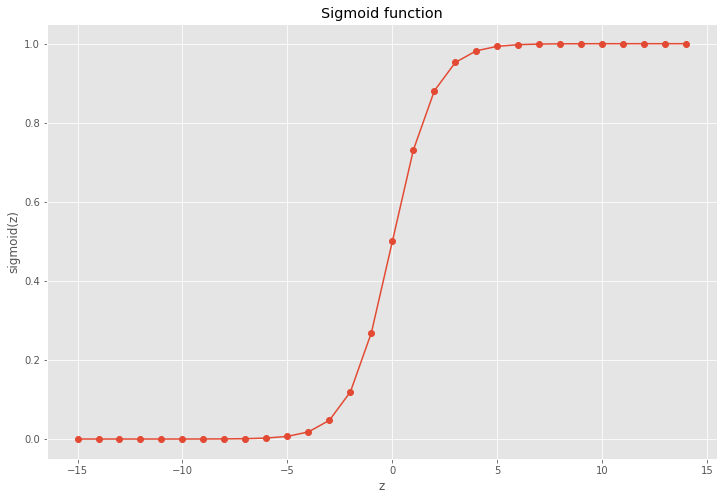

In [39]:
#some values between -15 and 15
z = np.arange(-15, 15)
#applying sigmoid to the values
s = sigmoid(z)

plt.plot(z, s, marker='o')
plt.title('Sigmoid function')
plt.xlabel('z')
plt.ylabel('sigmoid(z)')
plt.show()

## Cost function

The usual cost function for binary classification using logistic regression task is the *binary cross entropy* between our predicted value, $y_{pred}$, and the actual value, $y_{true}$:
$$cross\_entropy(y_{true}, y_{pred}) = -y_{true}\log(y_{pred}) - (1 - y_{true})\log(1 - y_{pred})$$

For each batch of $k$ examples, we have to compute the cross entropy for each example and then average the values:
$$J(\theta) = \frac{1}{m}\sum_{k=1}^{m} cross\_entropy(y_{true}^{(k)}, y_{pred}^{(k)})$$

In [15]:
def log(z, eps=1e-32):
    '''Numerically stable log'''
    return np.log(np.maximum(z, eps))


def binary_cross_entropy(y_true, y_pred):
    return -y_true*log(y_pred) - (1 - y_true)*log(1 - y_pred)


def cost(ys_true, ys_pred):
    '''Binary classification cost for one batch'''
    return binary_cross_entropy(ys_true, ys_pred).mean()

Let's try to gain some insights as to *why* we use cross-entropy instead of, say, squared error (which is used in linear regression). In order to do this, let's compare the values of both losses for some values:

In [16]:
def squared_error(y_true, y_pred):
    return (y_true - y_pred)**2


y_true = np.array([1, 1, 1, 1, 0, 0, 0, 0])
y_pred = np.array([0.001, 0.3, 0.6, 0.999, 0.999, 0.6, 0.3, 0.001])
errors = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred,
    'squared_error': squared_error(y_true, y_pred),
    'cross_entropy': binary_cross_entropy(y_true, y_pred),
})
print(errors)

   y_true  y_pred  squared_error  cross_entropy
0       1   0.001       0.998001       6.907755
1       1   0.300       0.490000       1.203973
2       1   0.600       0.160000       0.510826
3       1   0.999       0.000001       0.001001
4       0   0.999       0.998001       6.907755
5       0   0.600       0.360000       0.916291
6       0   0.300       0.090000       0.356675
7       0   0.001       0.000001       0.001001


As you can see, we can say that cross-entropy is much more "agressive" regarding wrong values. If the ground-truth value is 1, for example, the cost grows *much* quicker for values approaching 0 (line 1 of table above). It is analogous for values that should be 0 and are predicted as something close to 1. This is what we want in a classification task.

## Implementing Gradient Descent

Quick recap: gradient descent is an optimization method used to "adjust" the parameters ($\theta$) of our model in an iterative manner.

First, let's remember that our matrices are:
- $X$, of dimensions $m \times (n+1)$, (one $x$ per row, $x^k$ is the $x$ at the $k$th row); 
- $Y_{true}$, $Y_{pred}$, of dimensions $m \times 1$ (one $y_{true}$ or $y_{pred}$ per row);
- $\theta$, of dimensions $(n+1) \times 1$

With $m$ being the number of training examples and $n$ the number of $x$ variables (2 in our case).
 
#### Update step
Each "step" uses a batch of the training dataset to predict values, compute the cost and it's derivative w.r.t $\theta$ and adjust $\theta$. For each $\theta_{j}$, the step can be summarized as:

$$\theta_{j} = \theta_{j} - {learning\_rate}*\frac{\partial J}{\partial \theta_{j}}$$
$$\frac{\partial J}{\partial \theta_{j}} = \frac{1}{m}\sum_{k=1}^{m}\left(y_{pred}^{(k)} - y_{true}^{(k)}\right)x_{j}^{(k)}$$

This can be implemented as follows:

In [17]:
def cost_derivative_wrt_theta_j(xs, ys_true, ys_pred, j):
    m = len(xs)
    summ = 0
    for k in range(m):
        summ += (ys_pred[k] - ys_true[k])*xs[k][j]
    return (1/m)*summ


def gradient_descent_step_iter(xs, ys_true, ys_pred, theta, learning_rate):
    for j in range(theta.shape[0]):
        grad_j = cost_derivative_wrt_theta_j(xs, ys_true, ys_pred, j)
        theta[j] = theta[j] - learning_rate*grad_j
    return theta

Let's perform a single optimization step on some fake data just to have an idea on how much time it takes:

In [18]:
fake_xs = np.random.uniform(0, 10, size=(300000, 3))
fake_ys = np.random.randint(0, 2, size=(300000, 1))
fake_ys_pred = np.random.randint(0, 2, size=(300000, 1))
fake_theta = np.random.uniform(0, 3, size=(3, 1))

start = time.time()
gradient_descent_step_iter(fake_xs, fake_ys, fake_ys_pred, fake_theta, learning_rate=0.001)
iter_elapsed = time.time() - start

print(f'elapsed time for iterative gradient descent step: {iter_elapsed:.4f}s')

elapsed time for iterative gradient descent step: 5.8395s


That's a pretty significant amound of time for a single update step!
We now note that, although the previous methods are written in a way that's simple to understand, they're not very *efficient*. We're iterating a lot while we should be taking advantage of **vectorization**. We should always try to vectorize our code in order to allow numpy to perform a variety of optimizations, making it as fast as possible.

You can verify that we can compute all the derivatives of $\theta$ "at once" with one single matrix operation:
$$\frac{\partial J}{\partial \theta} = X^{T}\left(Y_{pred} - Y_{true}\right)$$
We can also update $\theta$ all at once:
$$\theta = \theta -{learning\_rate}*\frac{\partial J}{\partial \theta}$$

The following methods implement the same funcionality as the previous two methods, but it's now using vectorization:

In [19]:
def cost_derivative(xs, ys_true, ys_pred):
    return np.dot(xs.T, (ys_pred - ys_true))


def gradient_descent_step(xs, ys_true, ys_pred, theta, learning_rate):
    grad = cost_derivative(xs, ys_true, ys_pred)
    theta[:] = theta - learning_rate*grad
    return theta

Let's check how faster the new methods are:

In [69]:
start = time.time()
gradient_descent_step(fake_xs, fake_ys, fake_ys_pred, fake_theta, learning_rate=0.001)
vec_elapsed = time.time() - start

print(f'elapsed time for vectorized gradient descent step: {vec_elapsed:.4f}s')
print(f'vectorized GD was approximately {iter_elapsed/vec_elapsed:.4f} times faster')

elapsed time for vectorized gradient descent step: 0.0071s
vectorized GD was approximately 820.1156 times faster


[Hey, that's pretty good!](https://www.youtube.com/watch?v=JeimE8Wz6e4)

#### Gradient Descent loop
In the Gradient Descent optimization loop, we simply repeat the following steps:
  - Compute $y_{pred}$
  - Compute the $J(\theta)$ derivatives
  - Update $\theta$
  
for a certain number of times. Let's keep it simple and use the whole dataset as a batch. Thus, our number of update steps is equal to `n_epochs`.

It's also a good idea to monitor the validation loss. We do this in order to keep only the best values of $\theta$ (that is, the $\theta$ that scores the lowest loss on the validation set). We also store the train/validation losses for each iteration in order to plot it later.

In [21]:
def forward_step(xs, ys, theta):
    '''Predicts using given theta and calculates loss'''
    ys_pred = h_theta(xs, theta)
    loss = cost(ys, ys_pred)
    return ys_pred, loss


def gradient_descent(xs, ys, xs_val, ys_val, theta, learning_rate, n_epochs):
    #initial values for losses and best theta
    best_theta = theta.copy()
    ys_pred, loss = forward_step(xs, ys, theta)
    _, val_loss = forward_step(xs_val, ys_val, theta)
    best_val_loss = val_loss

    #evolution of train/validation loss along epochs
    history = {'loss': [loss], 'val_loss': [val_loss]}
    
    #main gradient descent loop
    for k in range(n_epochs):
        #adjust weights
        theta = gradient_descent_step(xs, ys, ys_pred, theta, learning_rate)

        #computing losses for new weights
        ys_pred, loss = forward_step(xs, ys, theta)
        _, val_loss = forward_step(xs_val, ys_val, theta)
        
        #if validation loss is the best so far, saves weights
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_theta = theta.copy()

        #appending losses to history
        history['loss'].append(loss)
        history['val_loss'].append(val_loss)
        
        print(f'[epoch #{k+1:04d}/{n_epochs:04d}',
            f'loss: {loss:.4f} | val loss: {val_loss:.4f}', end='\r')
    print()

    return best_theta, history

We're ready to train! We just need to convert our dataset to the appropriate matrix format first.
We've been dealing with a `pandas.DataFrame`so far, so we need to get a `numpy.ndarray`. Also, we need to create our "virtual" $x_0$ variables by appending ones to the $X$ (`xs`) matrix.

In [22]:
def prepend_ones(xs):
    ones = np.ones(shape=(xs.shape[0], 1), dtype=xs.dtype)
    return np.concatenate([ones, xs], axis=1)


def get_matrices(df):
    m = df.shape[0]
    xs = df[['x1', 'x2']].values.astype('float32')
    xs = prepend_ones(xs)
    ys = df.y.values.reshape((m, 1)).astype('float32')
    return xs, ys

In [23]:
xs_train, ys_train = get_matrices(df_train_norm)
xs_val, ys_val = get_matrices(df_val_norm)

print(f'from df_train of shape {df_train_norm.shape}:')
print(df_train[-5:])
print('...')
print(f'... to xs_train of shape {xs_train.shape}:')
print(xs_train[-5:])
print(f'... and ys_train of shape {ys_train.shape}:')
print(ys_train[-5:])

from df_train of shape (5594, 3):
            x1         x2  y
7548  6.683644  70.704229  0
7549  1.525537  68.325923  1
7550  5.130441  21.454031  0
7551  4.826012  87.533053  1
7552  2.023443  60.460569  1
...
... to xs_train of shape (5594, 3):
[[ 1.          0.5969694   0.5006743 ]
 [ 1.         -1.1986824   0.42628556]
 [ 1.          0.05626499 -1.0397756 ]
 [ 1.         -0.04971378  1.027047  ]
 [ 1.         -1.0253502   0.18027265]]
... and ys_train of shape (5594, 1):
[[0.]
 [1.]
 [0.]
 [1.]
 [1.]]


## Weights initialization

It's usually a good idea to initialize the weights ($\theta$) to some random values instead of zeros. `get_randomly_initialized_theta`, uses [Xavier initialization](https://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization) for the task.

We also implement zero-initialization for comparison purposes.

In [24]:
def get_randomly_initialized_theta(size, rand_seed=None):
    rand = np.random.RandomState(seed=rand_seed)
    sigma = np.sqrt(2/(size + 1))
    return sigma*rand.randn(size, 1)


def get_zero_initialized_theta(size):
    return np.zeros(shape=(size, 1)).astype('float32')

## Training routine

We can finally train our model! The following routine initializes weights then adjusts them using our `gradient_descent` method.

In [25]:
def train(xs_train, ys_train, xs_val, ys_val, learning_rate, n_epochs, theta_init='random'):
    #initial theta
    if theta_init == 'random':
        theta = get_randomly_initialized_theta(size=xs_train.shape[1], rand_seed=42)
    elif theta_init == 'zeros':
        theta = get_zero_initialized_theta(size=xs_train.shape[1])
    else:
        raise ValueError(f'invalid initialization mode "{theta_init}"')

    #gradient descent optimization
    theta, history = gradient_descent(
        xs_train, ys_train, xs_val, ys_val,
        theta,
        learning_rate, n_epochs)

    return theta, history

Before training, let's also write some methods to plot our train/validation losses evolution along the epochs.

In [26]:
def get_colors():
    colors = [
        '#348ABD',
        '#E24A33',
        '#A60628',
        '#467821',
        '#CF4457',
        '#7A68A6',
        '#188487',
    ]
    init_colors = set(colors)
    other_colors = sorted(mpl_colors.cnames.keys())
    colors.extend(c for c in other_colors if c not in init_colors)
    return colors


def plot_train_history(hist):
    keys = sorted(hist.keys())
    for k, c in zip(keys, get_colors()):
        plt.plot(hist[k], color=c)
    plt.legend(keys, loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('metric')
    plt.title('train metrics')
    plt.show()

It's finally time to train!

[epoch #0500/0500 loss: 0.1223 | val loss: 0.1203 loss: 0.1338 | val loss: 0.1328


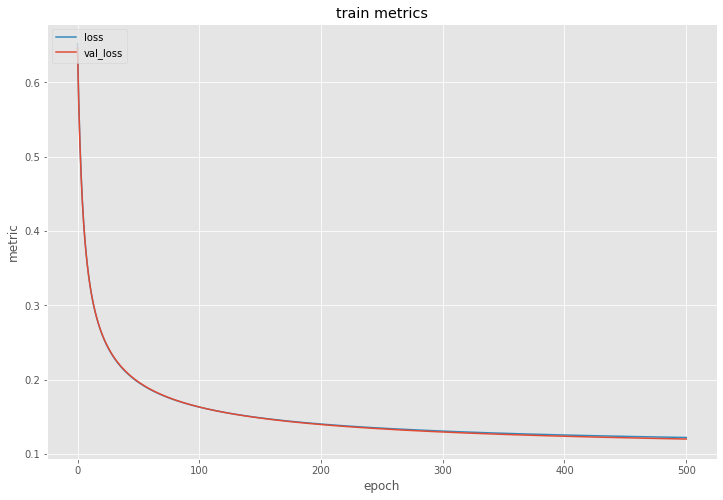

In [68]:
theta, history = train(
    xs_train, ys_train, xs_val, ys_val,
    learning_rate=0.0001,
    n_epochs=500,
    theta_init='random'
)
plot_train_history(history)

We can see the train/validation loss curves along time. For sufficiently small `learning_rate` and reasonable number of epochs, the plot should show loss convergence.

Note that we used a single learning rate because we tried to keep it simple, but you'll usually want to use some [*hyperparameter tuning*](https://www.geeksforgeeks.org/ml-hyperparameter-tuning/) (such as *grid search* or *random search*) to find the best learning rate and other hyperparameters. It also often makes sense to use something like [*K-fold cross validation*](https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f) instead of a fixed validation set.

## Evaluating the model

Now that we successfully trained our model, we need to try to answer the question: **How good is our model?**
For a binary classification task, there are some "canonical" metrics that are useful as a rule of thumb:
- **Accuracy**: simply a measure of the fraction of the predicted values that equal the true values. **Beware**! Accuracy can me *misleading* sometimes. If we have a very unbalanced dataset, for example, it can be easy to achieve a high accuracy (if 99% of the dataset is false examples and your model always outputs "false", you achieved 99% accuracy!)
- **Precision**: A metric to express how "safe" your model is. A high precision means that your model does not produce many false positives.
- **Recall**: A metric to express how "abrangent" your model is. A high recall means that your model does not produce many false negatives.
- **F1-score** How "balanced" your model is between precision and recall. High precision but low recall means your model is leaving behind too many positive examples, high recall and low precision means your model identifies most of positive examples but also misclassifies a lot of negatives as positives. Thus, it's important to have a good balance.

Another important concept is the [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix). From the confusion matrix, you can calculate a variety of other metrics.

We implement some metrics computation/plotting methods below.

In [28]:
def confusion_matrix(bin_ys_true, bin_ys_pred):
    true_positives = (bin_ys_true & bin_ys_pred).sum()
    true_negatives = ((bin_ys_true^1) & (bin_ys_pred^1)).sum()
    false_positives = bin_ys_pred.sum() - true_positives
    false_negatives = (bin_ys_pred^1).sum() - true_negatives
    return np.array([
        [true_positives, false_positives],
        [false_negatives, true_negatives]], dtype='int')


def accuracy(confusion_matrix):
    true_positives = confusion_matrix[0, 0]
    true_negatives = confusion_matrix[1, 1]
    total = confusion_matrix.sum()
    return (true_positives + true_negatives)/max(total, 1)


def precision(confusion_matrix):
    true_positives = confusion_matrix[0, 0]
    false_positives = confusion_matrix[0, 1]
    return true_positives/max(true_positives + false_positives, 1)


def recall(confusion_matrix):
    true_positives = confusion_matrix[0, 0]
    false_negatives = confusion_matrix[1, 0]
    return true_positives/max(true_positives + false_negatives, 1)


def f1_score(precision, recall):
    return 2*precision*recall/max(precision + recall, 1)


def get_metrics(ys_true, ys_pred):
    metrics = {}
    metrics['loss'] = cost(ys_true, ys_pred)

    bin_ys_true = ys_true.round().astype('uint8')
    bin_ys_pred = ys_pred.round().astype('uint8')
    conf_mtx = confusion_matrix(bin_ys_true, bin_ys_pred)
    metrics['accuracy'] = accuracy(conf_mtx)
    metrics['precision'] = precision(conf_mtx)
    metrics['recall'] = recall(conf_mtx)
    metrics['f1_score'] = f1_score(metrics['precision'], metrics['recall'])

    return pd.DataFrame(
        {'metric': list(metrics.keys()), 'value': list(metrics.values())},
        columns=['metric', 'value'])


def plot_confusion_matrix(ys_true, ys_pred, title='Confusion Matrix'):
    mtx = confusion_matrix(ys_true.round().astype('uint8'), ys_pred.round().astype('uint8'))
    fig, ax = plt.subplots(1)

    #setting bounding box
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')

    plt.title(title)
    #plt.colorbar()

    #setting ticks
    classes = ['Positive', 'Negative']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #number of ocurrences
    thr = mtx.max()/2
    for i, j in it.product(range(mtx.shape[0]), range(mtx.shape[1])):
        plt.text(j, i, mtx[i, j],
            horizontalalignment='center',
            color='white' if mtx[i, j] > thr else 'black')

    plt.grid(False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    #displaying matrix
    plt.imshow(mtx, interpolation='nearest', cmap='Blues')
    plt.show()

    return fig, ax

We can now write a wrapper method to perform a reasonably extensive evaluation of our model over some dataset.

In [29]:
def predict(xs, theta):
    ys = h_theta(xs, theta)
    return ys


def evaluate(ys_pred, ys_true):
    plot_confusion_matrix(ys_true, ys_pred)
    metrics = get_metrics(ys_true, ys_pred)
    pprint.pprint(metrics)

Let's first evaluate our model on our *validation* set.

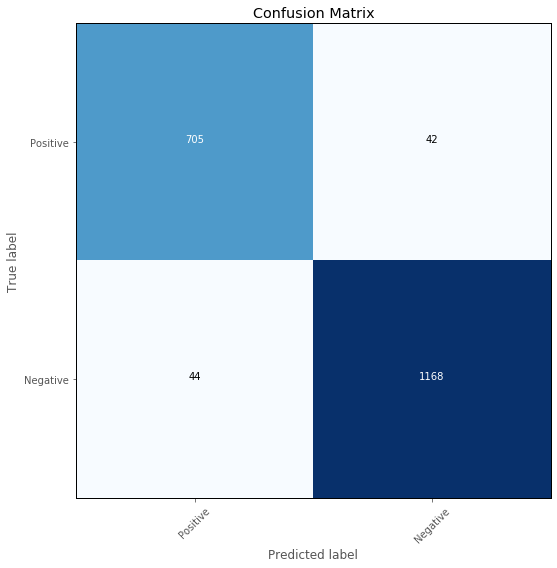

      metric     value
0       loss  0.120264
1   accuracy  0.956100
2  precision  0.943775
3     recall  0.941255
4   f1_score  0.942513


In [70]:
ys_val_pred = predict(xs_val, theta)
evaluate(ys_val_pred, ys_val)

These are pretty good numbers! We can now finally touch our *test* dataset. This is the moment of truth, the moment we find out whether or not our model suffers from terrible overfit. 

test set prediction examples:
         y_pred  y_true
0  2.159509e-03       0
1  5.342022e-07       0
2  3.543603e-08       0
3  9.999248e-01       1
4  9.995581e-01       1
5  5.023015e-03       0
6  9.969130e-01       1
7  3.454806e-06       0
8  5.143263e-02       0
9  8.980837e-01       1
test set evaluation:


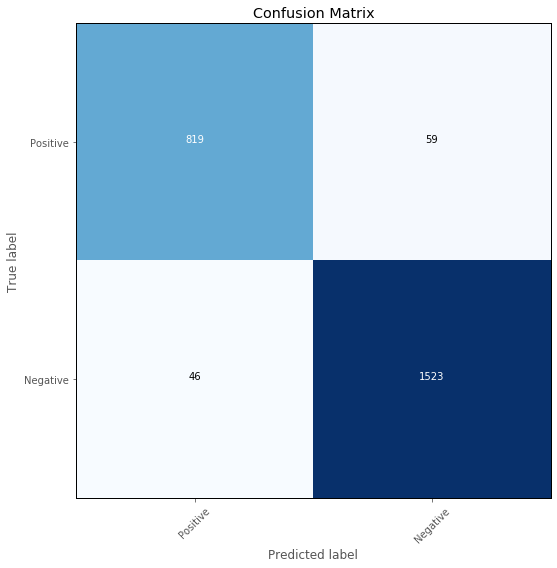

      metric     value
0       loss  0.114986
1   accuracy  0.957090
2  precision  0.932802
3     recall  0.946821
4   f1_score  0.939759


In [71]:
df_test_norm = normalize_dataset(df_test, train_stats)

xs_test, ys_test = get_matrices(df_test_norm)

ys_test_pred = predict(xs_test, theta)
df_preds = pd.DataFrame({'y_pred': ys_test_pred.flatten(), 'y_true': ys_test.astype('int').flatten()})
print('test set prediction examples:')
print(df_preds[:10])

print('test set evaluation:')
evaluate(ys_test_pred, ys_test)

Not bad! The metrics are *very slightly* worse than the validation set, but that's completely normal and expected. We can say our model achieved reasonable generalization.

## Decision boundary

We again take advantadge of the fact that our dataset is only 2-dimensional to plot the decision boundary corresponding to the $\theta$ we achieved:

In [72]:
def plot_decision_boundary(df, theta):
    df = df.sample(n=1000)
    visualize_classes(df, show=False, title='Decision boundary')
    
    x1 = np.arange(df.x1.min(), df.x1.max()*0.8, step=(df.x1.max() - df.x1.min()*0.8)/100)
    x2 = -(theta[0] + theta[1]*x1)/theta[2]
    plt.plot(x1, x2, color='blue')
    plt.show()

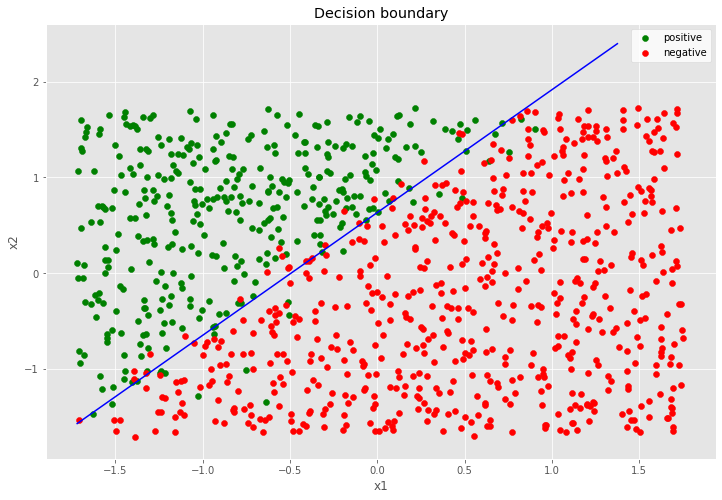

In [73]:
plot_decision_boundary(df_test_norm, theta)

That's it! Logistic Regression is a pretty simple yet very powerful algorithm. Why don't you explore some other [interesting problems](https://www.kaggle.com/tags/binary-classification) with the technique?